In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point,LineString
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# Reads in census files
us_county = gpd.read_file('tl_2020_us_county/tl_2020_us_county.shp')
us_state = gpd.read_file('tl_2020_us_state/tl_2020_us_state.shp')

# Filters counties, congressional districts, and state for IA and TX
iowa_county = us_county[us_county["STATEFP"] == '19']
#texas_county = us_county[us_county["STATEFP"] == '48']


iowa_state = us_state[us_state["STATEFP"] == '19']
#texas_state = us_state[us_state["STATEFP"] == '48']


# Adds election results to IA counties
iowa_results = pd.read_csv('iowa_2020_resultspop.csv')
iowa_county = iowa_county.merge(iowa_results, on = 'NAME', suffixes=('', '_y'))
iowa_county.drop([i for i in iowa_county.columns if '_y' in i], axis=1, inplace=True)

# Adds election results to TX counties
#texas_results = pd.read_csv('texas_2020_results.csv')
#texas_county = texas_county.merge(texas_results, on = 'NAME', suffixes=('', '_y'))
#texas_county.drop([i for i in texas_county.columns if '_y' in i],axis=1, inplace=True)


In [7]:
iowa_county[iowa_county['PARTY'] == 'R'].shape

(93, 20)

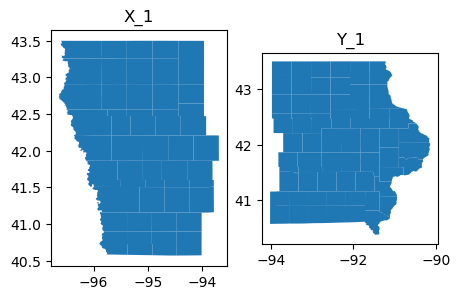

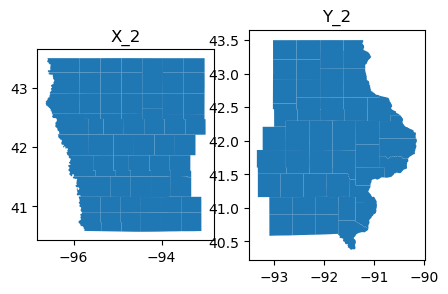

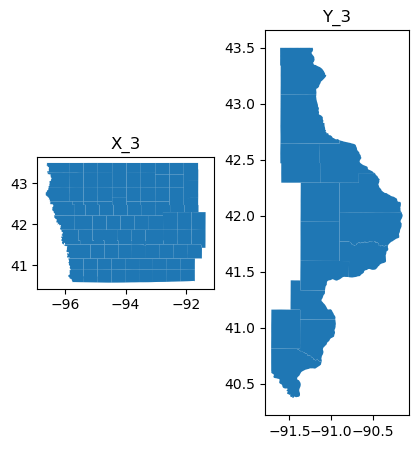

In [20]:
# Step 1: create i-splits for 1 <= i <= 3, stores each dataframe as a tuple in a list
# and prints each i-split

# Bookkeeping variables
total_pop = iowa_county['POP'].sum()
num_districts = 4 
pop_per_district = int(total_pop/num_districts)
min_x, min_y, max_x, max_y = iowa_county.total_bounds

# Creates an empty list and empty X_i and Y_i dataframes to store later
i_splits_hor = list()
j = min_x
step = 0.1
X_i = iowa_county.iloc[0:0]
Y_i = iowa_county.iloc[0:0]

# Cuts state vertically, moves a vertical line across the state and keeps track of which counties intersect the
# line, and keeps doing this until the population left of the line is the size needed for one (two, three) 
# district(s). Stores the (X_i,Y_i) pairs in a list and prints the maps.
for i in range(1,num_districts):
    
    while X_i['POP'].sum() <= ((i)*pop_per_district):
        X_i = iowa_county.cx[min_x:j, min_y:max_y]
        j += step
        continue
    X_i.reset_index(drop = True)
    Y_i = iowa_county.overlay(X_i, how = 'difference')
    Y_i.reset_index(drop = True)
    i_splits_hor.append((X_i,Y_i))
    
    fig, (ax1, ax2) = plt.subplots(ncols = 2,figsize = (5,5))
    X_i.plot(ax = ax1)
    ax1.set_title("X_"+str(i))
    Y_i.plot(ax = ax2)
    ax2.set_title("Y_"+str(i))
    fig.savefig("iowa "+str(i)+"-split.png",dpi = 300)
    
    #print(X_i['POP'].sum())
 



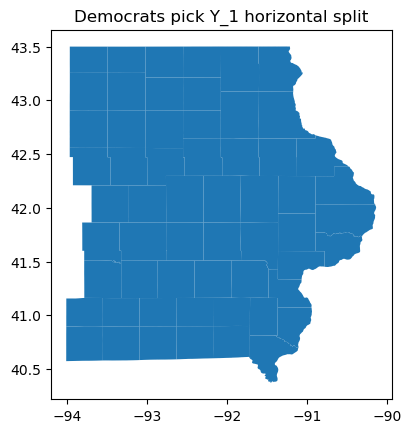

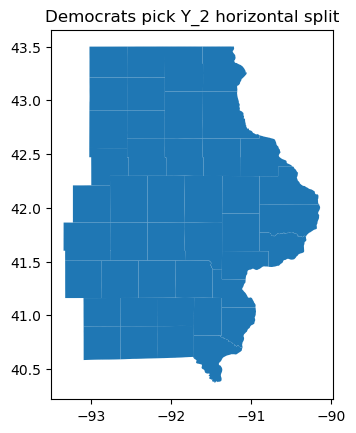

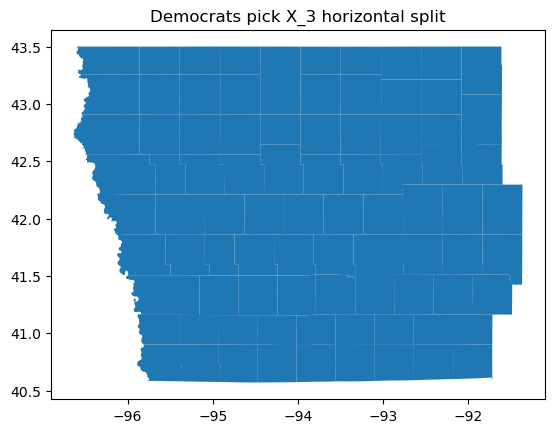

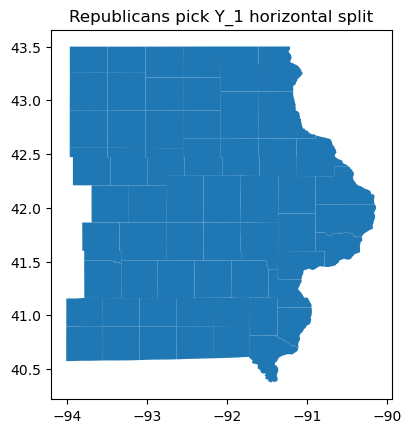

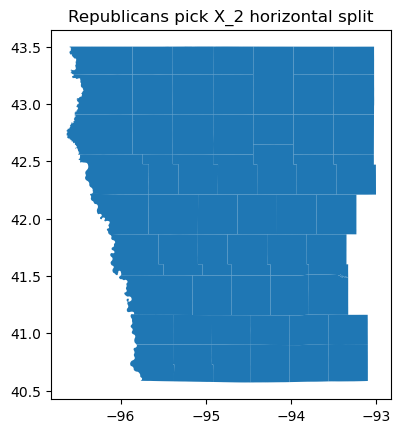

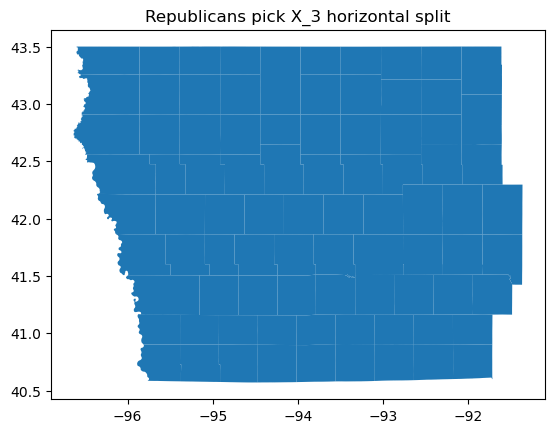

In [4]:
# Step 2: for each i, ask dems/reps which piece they'd like to prefer based on 
# number of counties each party won (reasoning in paper) storing their picks in lists

dem_picks_hor = list()
rep_picks_hor = list()

i = 1

# Democrats decide their horizontal split choice
for tup in i_splits_hor:
    X_i = tup[0]
    Y_i = tup[1]
    
    if X_i[X_i.PARTY == 'D'].shape[0] >= Y_i[Y_i.PARTY == 'D'].shape[0]:
        fig, ax = plt.subplots()
        X_i.plot(ax = ax)
        ax.set_title("Democrats pick X_"+str(i)+" horizontal split")
        dem_picks_hor.append((X_i,i,'X'))
        
    else:
        fig, ax = plt.subplots()
        Y_i.plot(ax = ax)
        ax.set_title("Democrats pick Y_"+str(i)+" horizontal split")
        dem_picks_hor.append((Y_i,i,'Y'))
        
    i+=1    

i = 1
# Republicans decide their horizontal split choice
for tup in i_splits_hor:
    X_i = tup[0]
    Y_i = tup[1]
    
    if X_i[X_i.PARTY == 'R'].shape[0] >= Y_i[Y_i.PARTY == 'R'].shape[0]:
        fig, ax = plt.subplots()
        X_i.plot(ax = ax)
        ax.set_title("Republicans pick X_"+str(i)+" horizontal split")
        rep_picks_hor.append((X_i,i,'X'))
        
    else:
        fig, ax = plt.subplots()
        Y_i.plot(ax = ax)
        ax.set_title("Republicans pick Y_"+str(i)+" horizontal split")
        rep_picks_hor.append((Y_i,i,'Y'))
        
    i += 1 
    


In [5]:
# Step 3: if there is an i such that both parties agree, make a division using that map
division_split_hor = list()

for i in range(len(dem_picks_hor)):
    if not pd.DataFrame.equals(dem_picks_hor[i][0],rep_picks_hor[i][0]):
        print("Democrats and Republicans both agree to divide the horizontal "+str(i+1)+"-split")
        division_split_hor.append((dem_picks_hor[i],rep_picks_hor[i]))
    else:
        print("Democrats and Republicans disagree on dividing the horizontal "+str(i+1)+"-split")
        

Democrats and Republicans disagree on dividing the horizontal 1-split
Democrats and Republicans both agree to divide the horizontal 2-split
Democrats and Republicans disagree on dividing the horizontal 3-split


In [6]:
# carbon copy for the horizontal splits  

# in the case theres an i in which both parties agree
if division_split_hor != []:
    #create division with this one!
    #Code that divides the split goes here:
    
    final_split = random.choice(division_split_hor)
    
    dem_split_hor = final_split[0][0]
    
    if final_split[0][2] == 'X':
        dem_i_hor = final_split[0][1]
    elif final_split[0][2] == 'Y':
        dem_i_hor = num_districts - final_split[0][1]
        
    rep_split_hor = final_split[1][0]
    
    if final_split[1][2] == 'X':
        rep_i_hor = final_split[1][1]
    elif final_split[1][2] == 'Y':
        rep_i_hor = num_districts - final_split[1][1]

    print(dem_i_hor)
    print(rep_i_hor)
    

# Case in which parties disagree for all i-splits
else:
    # Find an i_0 such that it abides with paper and pick one randomly
    
    i_0_hor = list()   # a list containing tuples of (i, i+1) splits satisfying step 4
    for j in range(len(i_splits_hor) - 1):
        X_i_1, Y_i_1 = i_splits_hor[j]
        X_i_2, Y_i_2 = i_splits_hor[j+1]
    
        if ((X_i_1[X_i_1.PARTY == 'D'].shape[0] <= Y_i_1[Y_i_1.PARTY == 'D'].shape[0]) and \
        (X_i_2[X_i_2.PARTY == 'D'].shape[0] >= Y_i_2[Y_i_2.PARTY == 'D'].shape[0])) or \
        ((X_i_1[X_i_1.PARTY == 'D'].shape[0] >= Y_i_1[Y_i_1.PARTY == 'D'].shape[0]) and \
        (X_i_2[X_i_2.PARTY == 'D'].shape[0] <= Y_i_2[Y_i_2.PARTY == 'D'].shape[0])):
            
            i_0_hor.append(((i_splits_hor[j],j+1),(i_splits_hor[j+1],j+2)))
        else:
            continue
    
    i_0_choice_hor = random.choice(i_0_hor)
    
    # Step 4 continued:
    option = random.randrange(1,5)

    if option == 1:
        # democrats divide X_i, reps divide Y_i (vertically)
        dem_split_hor = i_0_choice_hor[0][0][0]
        dem_i_hor = i_0_choice_hor[0][1]
        rep_split_hor = i_0_choice_hor[0][0][1]
        rep_i_hor = num_districts - i_0_choice_hor[0][1]
    
        
    
    elif option == 2:
        # democrats divide Y_i, reps divide X_i (vertically)
        dem_split_hor = i_0_choice_hor[0][0][1]
        dem_i_hor = num_districts - i_0_choice_hor[0][1]
        rep_split_hor = i_0_choice_hor[0][0][0]
        rep_i_hor = i_0_choice_hor[0][1]
        
        
    
    elif option == 3:
        # democrats divide X_i+1, reps divide Y_i+1 (vertically)
        dem_split_hor = i_0_choice_hor[1][0][0]
        dem_i_hor = i_0_choice_hor[1][1]
        rep_split_hor = i_0_choice_hor[1][0][1]
        rep_i_hor = num_districts - i_0_choice_hor[1][1]
        
        
    
    elif option == 4:
        # democrats divide Y_i+1, reps divide X_i+1 (vertically)
        dem_split_hor = i_0_choice_hor[1][0][1]
        dem_i_hor = num_districts - i_0_choice_hor[1][1]
        rep_split_hor = i_0_choice_hor[1][0][0]
        rep_i_hor = i_0_choice_hor[1][1]
    
        
    


2
2


In [7]:
#checks if one district is still underpopulated
def underpopulated(df,num_districts,pop):
    l = []
    for i in range(1,num_districts+1):
        district = df[df['DISTRICT'] == i]
        district_pop = district['POP'].sum()
        if district_pop <= pop:
            l.append(True)
        else:
            l.append(False)
    return l
        

In [8]:
#gets a list of indexes of the neighboring counties
def list_nb_index(nb_index):
    l = []
    j = 0
    for i in nb_index:
        if i == True:
            l.append(j)
            j += 1
        else:
            j += 1
            continue
    return l

In [9]:
#splits the piece 
def split(piece,num_districts,total_districts,party):
    
    #adds a column named 'district' and gets the counties from the party, sorting from largest to smallest
    piece['DISTRICT'] = 0
    counties = piece[piece['PARTY'] == party]
    counties_sorted = piece.sort_values(by = 'POP',ascending = False)

    
    if num_districts == 1:
        piece['DISTRICT'] = total_districts
        return piece
    else:
    
        # picks the starting district to be the largest county in the party
        for i in range(1,num_districts+1):
            piece.loc[counties_sorted.index[i-1],'DISTRICT'] = i
        
    
        piece.sort_index(inplace = True)
    
        target_pop = piece['POP'].sum()/num_districts
    
        # while any one district is underpopulated, do:
        while any(underpopulated(piece,num_districts,target_pop)):
        
            # pick a random district
            i = random.randrange(1,num_districts+1)
            district = piece[piece['DISTRICT'] == i]
        
            #get all the unassigned counties
            unassigned_counties = piece.loc[piece['DISTRICT'] == 0,:]
            unassigned_counties.sort_index(inplace = True)
        
            #make the district into one giant piece
            unary_district = district['geometry'].unary_union
        
            #gets the indices for all the neighbors to the district
            nb_id = unassigned_counties['geometry'].touches(unary_district)
            list_nb_id = list_nb_index(nb_id)
        
            #handles the case if things go wrong
            if list_nb_id == [0] or list_nb_id == []:
                break
            else:
                # if things dont go wrong, select a neighbor at random
                all_nb = unassigned_counties.iloc[list_nb_id,:]
                nb = all_nb.sample()
                nb_name = nb.iloc[0,nb.columns.get_loc('NAME')]
            
                #if adding the neighbor doesnt go over the target pop, add it to the district
                if (district['POP'].sum() + nb['POP'].sum()) <= target_pop:
                    piece.loc[piece['NAME'] == nb_name, 'DISTRICT'] = i
           
    
        #once things go wrong, gets all the leftover unassigned counties
        unassigned_counties = piece.loc[piece['DISTRICT'] == 0,:]
        uc_index = [i for i in unassigned_counties.index]
    
        districts_geom = []

    
        for i in range(1,num_districts+1):
            district_i = piece[piece['DISTRICT'] == i]
            district_i_geom = district_i['geometry'].unary_union
            districts_geom.append(district_i_geom)
        
        for district in districts_geom:
            touches_bool = unassigned_counties.intersects(district)
            if any(touches_bool):
                district_i_num = districts_geom.index(district)+1
                piece.loc[uc_index,'DISTRICT'] = district_i_num
                    
        
        return piece



In [10]:
#splits the piece 
def split2(piece,num_districts,total_districts,party):
    
    #adds a column named 'district' and gets the counties from the party, sorting from largest to smallest
    piece['DISTRICT'] = 0
    counties = piece[piece['PARTY'] == party]
    counties_sorted = piece.sort_values(by = 'POP',ascending = False)

    
    if num_districts == 1:
        piece['DISTRICT'] = total_districts
        return piece
    else:
    
        # picks the starting district to be the largest county in the party
        for i in range(1,num_districts+1):
            piece.loc[counties_sorted.index[i-1],'DISTRICT'] = i
        
    
        piece.sort_index(inplace = True)
    
        target_pop = piece['POP'].sum()/num_districts
    
        # while any one district is underpopulated, do:
        while any(underpopulated(piece,num_districts,target_pop)):
        
            # pick a random district
            i = random.randrange(1,num_districts+1)
            district = piece[piece['DISTRICT'] == i]
        
            #get all the unassigned counties
            unassigned_counties = piece.loc[piece['DISTRICT'] == 0,:]
            unassigned_counties.sort_index(inplace = True)
        
            #make the district into one giant piece
            unary_district = district['geometry'].unary_union
        
            #gets the indices for all the neighbors to the district
            nb_id = unassigned_counties['geometry'].touches(unary_district)
            list_nb_id = list_nb_index(nb_id)
        
            #handles the case if things go wrong
            if list_nb_id == [0] or list_nb_id == []:
                break
            else:
                # if things dont go wrong, select a neighbor at random
                all_nb = unassigned_counties.iloc[list_nb_id,:]
                nb = all_nb.sample()
                nb_name = nb.iloc[0,nb.columns.get_loc('NAME')]
            
                #if adding the neighbor doesnt go over the target pop, add it to the district
                if (district['POP'].sum() + nb['POP'].sum()) <= target_pop:
                    piece.loc[piece['NAME'] == nb_name, 'DISTRICT'] = i
           
    
        #once things go wrong, gets all the leftover unassigned counties
        unassigned_counties = piece.loc[piece['DISTRICT'] == 0,:]
        uc_index = [i for i in unassigned_counties.index]
        unassigned_counties.reset_index(drop = True)
    
        districts_geom = []
    
        for i in range(1,num_districts+1):
            district_i = piece[piece['DISTRICT'] == i]
            district_i_geom = district_i['geometry'].unary_union
            disConvexHull = district_i_geom.convex_hull
            districts_geom.append(disConvexHull)
        
        for district in districts_geom:
            touches_bool = unassigned_counties.intersects(district)
            for i in range(unassigned_counties.shape[0]):
                county = unassigned_counties.iloc[i]
                if county['geometry'].intersects(district):
                    district_i_num = districts_geom.index(district)+1
                    piece.loc[uc_index[i],'DISTRICT'] = district_i_num
                    
        return piece



<AxesSubplot:>

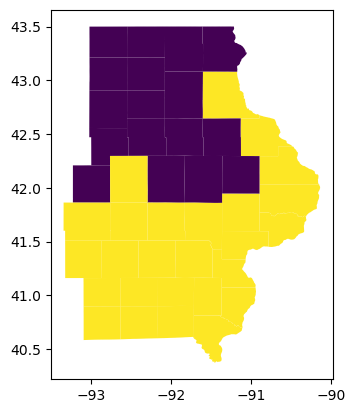

In [11]:
dem = split(dem_split_hor,dem_i_hor,4,'D')
dem.plot(column = 'DISTRICT')

/Users/sarahmendozadelacruz/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

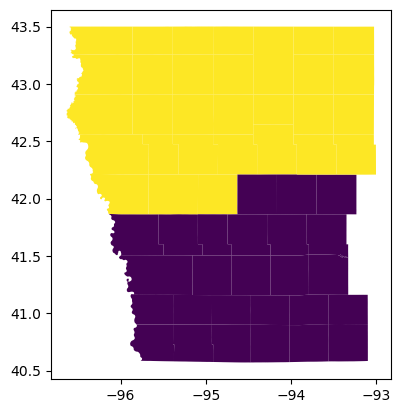

In [12]:
rep = split(rep_split_hor,rep_i_hor,4,'R')
rep.plot(column = 'DISTRICT')

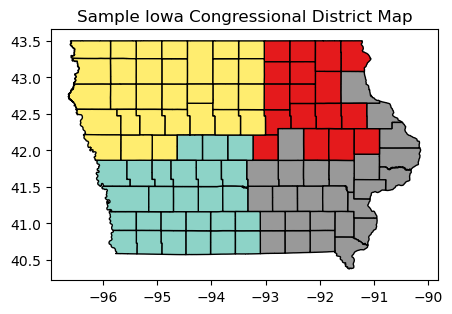

In [18]:
fig,ax = plt.subplots(figsize = (5,5))
dem.plot(ax = ax,column = 'DISTRICT',cmap = 'Set1',edgecolor = 'black')
rep.plot(ax = ax,column = 'DISTRICT',cmap = 'Set3',edgecolor = 'black')
plt.title("Sample Iowa Congressional District Map")
fig.savefig("sampleIowaPlan.png",dpi=300)

district 1 dem votes: 230299 rep votes: 432822
district 2 dem votes: 458667 rep votes: 458080


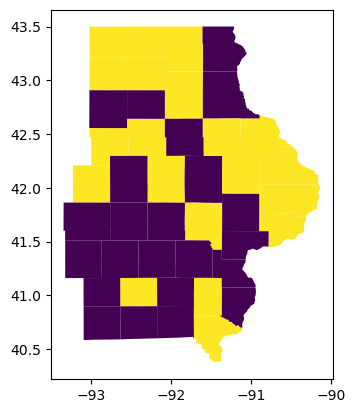

In [17]:
final_splitD = split(dem_split_hor,dem_i_hor,4,'D')
votes_by_dis = []
dem_votes = []


if dem_i_hor == 1:
    final_splitD.plot(column = 'DISTRICT')
else:
    
    for i in range(1,dem_i_hor+1):
        dis_i = final_splitD[final_splitD['DISTRICT'] == i]
        disVotesD = dis_i[dis_i['PARTY'] == 'D']['POP'].sum()
        disVotesR = dis_i[dis_i['PARTY'] == 'R']['POP'].sum()
        votes_by_dis.append((disVotesD,disVotesR))
        if disVotesD <= disVotesR:
            dem_votes.append(False)
        elif disVotesD >= disVotesR:
            dem_votes.append(True)


    while any(dem_votes) == False:
        final_splitD = split(dem_split_hor,dem_i_hor,4,'D')
        votes_by_dis = []
        dem_votes = []
        for i in range(1,dem_i_hor+1):
            dis_i = final_splitD[final_splitD['DISTRICT'] == i]
            disVotesD = dis_i[dis_i['PARTY'] == 'D']['POP'].sum()
            disVotesR = dis_i[dis_i['PARTY'] == 'R']['POP'].sum()
            votes_by_dis.append((disVotesD,disVotesR))
            if disVotesD <= disVotesR:
                dem_votes.append(False)
            elif disVotesD >= disVotesR:
                dem_votes.append(True)
    

    for i in range(1,dem_i_hor+1):
        dis = final_splitD[final_splitD['DISTRICT'] == i]
        dvotes = dis[dis['PARTY'] == 'D']['POP'].sum()
        rvotes = dis[dis['PARTY'] == 'R']['POP'].sum()
        print("district "+str(i)+" dem votes: "+str(dvotes)+" rep votes: "+str(rvotes))
    
    final_splitD.plot(column = 'DISTRICT')

numpy.int64

In [18]:
demSamples = []
c = 0
for i in range(200):
    demSplit = split(dem_split_hor,dem_i_hor,4,'D')
    
    #put just in case something goes wrong and any dis == 0
    dis_list = [i for i in demSplit['DISTRICT']]
    
    if dis_list.count(0) == 0:
    
        demWon = 0
        repWon = 0

        for i in range(1,dem_i_hor+1):
            dis = demSplit[demSplit['DISTRICT'] == i]
            dvotes = dis[dis['PARTY'] == 'D']['POP'].sum()
            rvotes = dis[dis['PARTY'] == 'R']['POP'].sum()
            if dvotes >= rvotes:
                demWon += 1
            elif rvotes >= dvotes:
                repWon += 1

        demSamples.append((demWon,repWon))
        c+=1
        print(c)
        
    else:
        c+=1
        
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [29]:
#dem wins on dem piece

dem = 0
for i in range(len(demSamples)):
    dem += demSamples[i][0]
    
print(dem)

102
0.255
200


In [31]:
#rep wins on dem piece

rep = 0
for i in range(len(demSamples)):
    rep += demSamples[i][1]
    

print(rep)
print(len(demSamples))

2.98
200


In [23]:
print(dem/rep)

0.3422818791946309


In [ ]:
final_splitR = split(rep_split_hor,rep_i_hor,4,'R')
votes_by_dis = []
rep_votes = []


if rep_i_hor == 1:
    final_splitR.plot(column = 'DISTRICT')
else:
    
    for i in range(1,rep_i_hor+1):
        dis_i = final_splitR[final_splitR['DISTRICT'] == i]
        disVotesD = dis_i[dis_i['PARTY'] == 'D']['POP'].sum()
        disVotesR = dis_i[dis_i['PARTY'] == 'R']['POP'].sum()
        votes_by_dis.append((disVotesD,disVotesR))
        if disVotesD >= disVotesR:
            rep_votes.append(False)
        elif disVotesD <= disVotesR:
            rep_votes.append(True)


    while any(rep_votes) == False:
        final_splitR = split(rep_split_hor,rep_i_hor,4,'R')
        votes_by_dis = []
        rep_votes = []
        for i in range(1,dem_i_hor+1):
            dis_i = final_splitR[final_splitR['DISTRICT'] == i]
            disVotesD = dis_i[dis_i['PARTY'] == 'D']['POP'].sum()
            disVotesR = dis_i[dis_i['PARTY'] == 'R']['POP'].sum()
            votes_by_dis.append((disVotesD,disVotesR))
            if disVotesD >= disVotesR:
                dem_votes.append(False)
            elif disVotesD <= disVotesR:
                dem_votes.append(True)
    

    for i in range(1,rep_i_hor+1):
        dis = final_splitR[final_splitR['DISTRICT'] == i]
        dvotes = dis[dis['PARTY'] == 'D']['POP'].sum()
        rvotes = dis[dis['PARTY'] == 'R']['POP'].sum()
        print("district "+str(i)+" dem votes: "+str(dvotes)+" rep votes: "+str(rvotes))
    
    final_splitR.plot(column = 'DISTRICT')

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
final_splitR.plot(ax = ax,column = 'DISTRICT',cmap = 'Set1',edgecolor = 'black')
final_splitD.plot(ax = ax,column = 'DISTRICT',cmap = 'Set3',edgecolor = 'black')

In [21]:
repSamples = []
c = 0
for i in range(200):
    repSplit = split(rep_split_hor,rep_i_hor,4,'R')
    
    #put just in case something goes wrong and any dis == 0
    dis_list = [i for i in repSplit['DISTRICT']]
    
    if dis_list.count(0) == 0:
    
        demWon = 0
        repWon = 0

        for i in range(1,rep_i_hor+1):
            dis = repSplit[repSplit['DISTRICT'] == i]
            dvotes = dis[dis['PARTY'] == 'D']['POP'].sum()
            rvotes = dis[dis['PARTY'] == 'R']['POP'].sum()
            if dvotes >= rvotes:
                demWon += 1
            elif rvotes >= dvotes:
                repWon += 1

        repSamples.append((demWon,repWon))
        c+=1
        print(c)
    else:
        c+=1
        
        

/Users/sarahmendozadelacruz/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sarahmendozadelacruz/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/sarahmendozadelacruz/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be s

In [32]:
# dem wins on rep piece

dem = 0
for i in range(len(repSamples)):
    dem += repSamples[i][0]
    

print(dem)
print(len(repSamples))



198
200


In [33]:
# rep wins on rep piece

rep = 0
for i in range(len(repSamples)):
    rep += repSamples[i][1]
    

print(rep)
print(len(repSamples))



202
200


In [27]:
print(dem/rep)

0.9801980198019802


<AxesSubplot:>

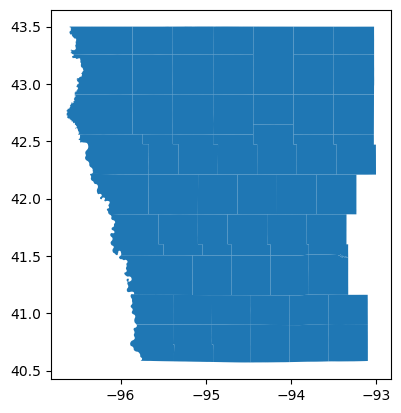

In [12]:
rep_split_hor.plot()

<AxesSubplot:>

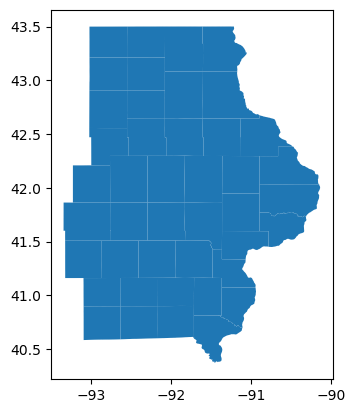

In [11]:
dem_split_hor.plot()